In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
# copy file in colab
!cp '/content/drive/MyDrive/Data/Idea Data/Idea-Dataset-(ALL bike Included).zip' ./
!cp '/content/drive/MyDrive/Data/Idea Data/wpod_net_org.h5' ./
!cp '/content/drive/MyDrive/Data/Idea Data/wpod-net-input_modified.json' ./

In [ ]:
!unzip -q 'Idea-Dataset-(ALL bike Included).zip' -d ./

In [ ]:
model_dir = "/content/drive/MyDrive/Data/weights/Idea/"

**Importing Main Linraries**

In [ ]:
import os
import glob
import random
import time
import json
import math
import shutil
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image, ImageDraw 

from sklearn.model_selection import train_test_split
import tensorflow as tf

# Machine Learning Problem

* This task is Multi-Output Regression problem.
* Model must predict four coordinates (i.e. 8 values)
* Minimum and maximum possible value of `y` (i.e. height) can be 0 and 120 respectively.
* Minimum and maximum possible value of `x` (i.e. width) can be 0 and 480 respectively. 


**Loss function will be MSE (mean sqaured error)**

The worst MSE value for a coordinate is:
* $(120-0)^2 + (480-0)^2 = 236800$

So the worst avg MSE for 4 coordinates will be $4*236800/(1*4) = 236800$.

This means any reasonable model will have MSE value lower than above value.

**Performance metric will be MAE (mean absolute error)**

The worst MAE value for a cooridnate is:
    * $|120-0| + |480-0| = 600$
    
So the worst MAE for MAE for 4 coordinates will be $4*600/(4*1) = 600$

In [ ]:
PATH = './'
folder = "final-mixed"
json_file = 'final-mixed.json'
json_file2 = 'special.json'
height=120
width=480

test_size = 0.05

**Read Json file that contain coordinates**

In [ ]:
os.listdir(model_dir)

['Custom-1',
 'Custom-2',
 'InceptionResNetV2',
 'InceptionV3',
 'ResNet50',
 'Xception',
 'idea_WPodNet_top_train.h5',
 'idea_WPodNet_top_train.csv',
 'idea_custom_2_top_train_rmsprop_mse.csv',
 'WPodNet-1',
 'WPodNet-0']

In [ ]:
with open(os.path.join(PATH, json_file), 'r') as f:
    label_data = json.load(f)

with open(os.path.join(PATH, json_file2), 'r') as f:
    label_data1 = json.load(f)

print("Total Number of train data point: {:,}".format(len(label_data)))
print("Total Number of test data point: {:,}".format(len(label_data1)))

Total Number of train data point: 8,900
Total Number of test data point: 118


**Function to convert coords**

In [ ]:
def resized_coords(coords, org_w, org_h, h=120, w=480):
    """
    function that returns the coordinates after reshaping the images
    """
    new = []
    for coord in coords:
        x, y = coord
        x = int(w*x/org_w)
        y = int(h*y/org_h)
        new.append([x,y])
    return new

**Filtering gray and colored images**

In [ ]:
Names = []
Classes = []

for key, val in tqdm(label_data.items()):
    Names.append(key)
    if val.get('type') == 'colored':
        Classes.append(1)
    elif val.get('type') == 'gray':
        Classes.append(0)
    else:
        print(f"for file name `{key}`, unknown type")

100%|██████████| 8900/8900 [00:00<00:00, 1222989.40it/s]


**Data Spliting (5% validatin data)**

In [ ]:
Classes.count(0), Classes.count(1)

(3044, 5856)

In [ ]:
train, val = train_test_split(Names, test_size = test_size, stratify = Classes, random_state = 42)
train_label, val_label, test_label = [], [], []


gtr, ctr = 0,0

for i in tqdm(train):
    coord = label_data[i]["coords"]
    org_w, org_h = label_data[i]["size"]["width"], label_data[i]["size"]["height"]
    coord = resized_coords(coord,org_w, org_h, height, width)
    train_label.append(coord)
   
    if Classes[Names.index(i)]==1:
        ctr += 1
    else:
        gtr += 1
        
print(f"\nIn train there are: {ctr}-colored and {gtr}-gray images. So % of gray is: {100*gtr/len(train)}%")

gtr, ctr = 0,0
for i in tqdm(val):
    coord = label_data[i]["coords"]
    org_w, org_h = label_data[i]["size"]["width"], label_data[i]["size"]["height"]
    coord = resized_coords(coord,org_w, org_h, height, width)
    val_label.append(coord)
    
    if Classes[Names.index(i)]==1:
        ctr += 1
    else:
        gtr += 1
        
print(f"\nIn validation there are: {ctr}-colored and {gtr}-gray images. So % of gray is: {100*gtr/len(val)}%")

for key in tqdm(label_data1.keys()):
    coord = label_data1[key]
    img = cv2.imread(os.path.join("./special-plates", key))
    org_h, org_w, _ = img.shape
    coord = resized_coords(coord,org_w, org_h, height, width)
    test_label.append(coord)

 21%|██        | 25/118 [00:00<00:00, 214.48it/s]


In train there are: 5563-colored and 2892-gray images. So % of gray is: 34.20461265523359%

In validation there are: 293-colored and 152-gray images. So % of gray is: 34.157303370786515%


100%|██████████| 118/118 [00:01<00:00, 92.77it/s]


In [ ]:
flatten_coords = lambda coords: [i[0] for i in coords] + [i[1] for i in coords]
reshape_coords = lambda coords: [[i,j] for i,j in zip(coords[:4], coords[4:])]

cols = ['coords-0-0', 'coords-1-0', 'coords-2-0', 'coords-3-0', 
        'coords-0-1', 'coords-1-1', 'coords-2-1', 'coords-3-1']

train_df = pd.DataFrame(columns = ["filename"])
train_df['filename']= train
train_df[cols]= np.array([flatten_coords(i) for i in train_label])

val_df = pd.DataFrame(columns = ["filename"])
val_df['filename']= val
val_df[cols]= np.array([flatten_coords(i) for i in val_label])

test_df = pd.DataFrame(columns = ["filename"])
test_df['filename']= list(label_data1.keys())
test_df[cols]= np.array([flatten_coords(i) for i in test_label])

assert len(train_df) == len(train)
assert len(val_df) == len(val)
assert len(test_df) == len(label_data1)


train_df.head()

,filename,coords-0-0,coords-1-0,coords-2-0,coords-3-0,coords-0-1,coords-1-1,coords-2-1,coords-3-1
0,69b98f9f3f547a57-0.png,43,436,415,43,2,14,110,103
1,19530-0.png,63,447,432,47,19,32,120,97
2,d7f1af9890d4f0b0-0.png,42,421,450,67,66,6,49,113
3,5dd346a3791a1054-0.png,15,469,469,15,16,50,116,76
4,1_uk_YY67SDZ_15856044.jpg,48,384,452,109,28,6,90,112


**Demo**

orginal shape:  (60, 70, 3)
current shape:  (120, 480, 3)


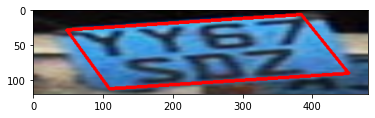

In [ ]:
index = 4
img = cv2.imread(os.path.join(os.path.join(PATH, folder), train[index]))
print("orginal shape: ", img.shape)
img = cv2.resize(img, (width, height))
print("current shape: ", img.shape)

coords = train_label[index]
img = cv2.line(img, tuple(coords[0]), tuple(coords[1]), (0,0,255), 4)
img = cv2.line(img, tuple(coords[1]), tuple(coords[2]), (0,0,255), 4)
img = cv2.line(img, tuple(coords[2]), tuple(coords[3]), (0,0,255), 4)
img = cv2.line(img, tuple(coords[3]), tuple(coords[0]), (0,0,255), 4)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# DL Model

**How Datagenration works**

Found 8455 validated image filenames.


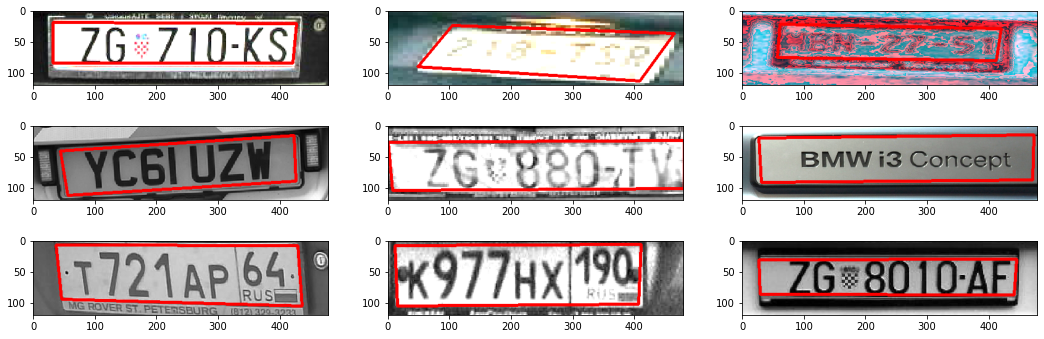

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(brightness_range = [0.6, 1.9],
                                                                rescale=1.0/255)
# train_datagen.fit(np.array(xtr_gen_fit))
for X_batch, coordss in train_datagen.flow_from_dataframe(dataframe = train_df, 
                                                   directory=os.path.join(PATH, folder), 
                                                   x_col='filename', 
                                                   y_col = cols,
                                                   target_size=(120, 480),
                                                   color_mode='rgb', classes=None,
                                                   class_mode='raw', batch_size=9):
    plt.figure(figsize = (18,6))
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        
        coords = coordss[i]
        coords = reshape_coords(coords)
        img = np.uint8(255*X_batch[i])
        img = cv2.line(img, tuple(coords[0]), tuple(coords[1]), (255,0,0), 4)
        img = cv2.line(img, tuple(coords[1]), tuple(coords[2]), (255,0,0), 4)
        img = cv2.line(img, tuple(coords[2]), tuple(coords[3]), (255,0,0), 4)
        img = cv2.line(img, tuple(coords[3]), tuple(coords[0]), (255,0,0), 4)
        plt.imshow(img)
    # show the plot
    plt.show()
    break

## Architectures

In [ ]:
batch_size = 32

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(brightness_range = [0.6, 1.9],
                                                                rescale=1.0/255)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)


train_generator = train_datagen.flow_from_dataframe(dataframe = train_df, 
                                                    directory=os.path.join(PATH, folder), 
                                                    x_col='filename', y_col = cols,
                                                    target_size=(120, 480),
                                                    color_mode='rgb', classes=None,
                                                    class_mode='raw', batch_size=batch_size)


val_generator = val_datagen.flow_from_dataframe(dataframe = val_df, 
                                                directory=os.path.join(PATH, folder), 
                                                x_col='filename', y_col = cols, 
                                                target_size=(120, 480),
                                                color_mode='rgb', classes=None,
                                                class_mode='raw', batch_size=batch_size)

test_generator = val_datagen.flow_from_dataframe(dataframe = test_df, 
                                                directory=os.path.join("./", "special-plates"), 
                                                x_col='filename', y_col = cols, 
                                                target_size=(120, 480),
                                                color_mode='rgb', classes=None,
                                                class_mode='raw', batch_size=batch_size)

Found 8455 validated image filenames.
Found 445 validated image filenames.
Found 118 validated image filenames.


### With `WPod-Net`

#### **Training only top layers (custom made)**

In [ ]:
base_model1 = tf.keras.models.load_model('./wpod_net_org.h5')

with open("./wpod-net-input_modified.json", "r") as f:
    a = json.load(f)
    a = json.dumps(a)
    base_model2 = tf.keras.models.model_from_json(a)
    
# print(base_model1.summary())

# print("\n\n\n")

# print(base_model2.summary())


for i in range(len(base_model2.layers[1].get_weights())):
    if not np.all(base_model1.layers[1].get_weights()[0] == base_model2.layers[1].get_weights()[0]):
        print("intial weights of both models are not same")
    else:
        print("intial weights of both models are same")
        

intial weights of both models are not same
intial weights of both models are not same


In [ ]:
# https://stackoverflow.com/a/55146535
for layer in base_model2.layers:
    try:
        layer.set_weights(base_model1.get_layer(name = layer.name).get_weights())
    except:
        print(f"{layer.name} is not present in base_model-1")

print("\n\n")

# to cross-check that intialized weights of both models are same
for i in range(len(base_model2.layers[1].get_weights())):
    assert np.all(base_model1.layers[1].get_weights()[0] == base_model2.layers[1].get_weights()[0])

base_model2.trainable = False
x = tf.keras.layers.Flatten(name = "flatten")(base_model2.output)
x = tf.keras.layers.Dense(units = 8, activation = "linear", name="output")(x)
model = tf.keras.Model(inputs = base_model2.input, outputs = x, name = "wpot-net-based-model")
model.summary()

new_input is not present in base_model-1



Model: "wpot-net-based-model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
new_input (InputLayer)          [(None, 120, 480, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 120, 480, 16) 448         new_input[0][0]                  
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 120, 480, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 120, 480, 16) 0           batch_normalization_1[0][0]      
___________________________________

##### **RMSProp optimizer**

In [ ]:
callbacks = [
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.25, patience=10, restore_best_weights=False,),
             tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(model_dir+"WPodNet-1", 'idea_WPodNet1_top_train.h5'),
                                                monitor='val_loss', save_best_only=True, mode = 'min'),
             tf.keras.callbacks.CSVLogger(os.path.join(model_dir+"WPodNet-1", 'idea_WPodNet1_top_train_rmsprop.csv'))
             ]

model.compile(optimizer = 'rmsprop', loss = 'mse', metrics =[tf.keras.metrics.MeanAbsoluteError()])
model.fit_generator(generator=train_generator, steps_per_epoch=math.ceil(len(train) / batch_size),
                  validation_data=val_generator, validation_steps=math.ceil(len(val) / batch_size),
                  callbacks=callbacks, epochs=1000,)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/1000
265/265 [==============================] - 40s 122ms/step - loss: 38199.9866 - mean_absolute_error: 117.5845 - val_loss: 14764.6846 - val_mean_absolute_error: 69.6746
Epoch 2/1000
265/265 [==============================] - 31s 118ms/step - loss: 10355.5865 - mean_absolute_error: 58.0328 - val_loss: 1722.2271 - val_mean_absolute_error: 24.0772
Epoch 3/1000
265/265 [==============================] - 31s 117ms/step - loss: 1101.5745 - mean_absolute_error: 19.3272 - val_loss: 962.1622 - val_mean_absolute_error: 16.4085
Epoch 4/1000
265/265 [==============================] - 30s 114ms/step - loss: 887.7516 - mean_absolute_error: 15.8729 - val_loss: 876.1530 - val_mean_absolute_error: 15.2295
Epoch 5/1000
265/265 [==============================] - 30s 114ms/step - loss: 673.6650 - mean_absolute_error: 14.5698 - val_loss: 812.9208 - val_mean_absolute_error: 14.5548
Epoch 6/1000
265/265 [==============================] - 30s 114ms/step - loss: 642.3042 - mean_absolute_error: 13.82

##### **Adam Optimizer**

In [ ]:
callbacks = [
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.25, patience=10, restore_best_weights=False,),
             tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(model_dir+"WPodNet-1", 'idea_WPodNet1_top_train.h5'),
                                                monitor='val_loss', save_best_only=True, mode = 'min'),
             tf.keras.callbacks.CSVLogger(os.path.join(model_dir+"WPodNet-1", 'idea_WPodNet1_top_train_adam.csv'))
             ]

model.compile(optimizer = 'adam', loss = 'mse', metrics =[tf.keras.metrics.MeanAbsoluteError()])
model.fit_generator(generator=train_generator, steps_per_epoch=math.ceil(len(train) / batch_size),
                  validation_data=val_generator, validation_steps=math.ceil(len(val) / batch_size),
                  callbacks=callbacks, epochs=1000,)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/1000
265/265 [==============================] - 32s 116ms/step - loss: 401.7003 - mean_absolute_error: 9.7984 - val_loss: 570.6999 - val_mean_absolute_error: 10.5915
Epoch 2/1000
265/265 [==============================] - 30s 114ms/step - loss: 386.2226 - mean_absolute_error: 9.6474 - val_loss: 571.9573 - val_mean_absolute_error: 10.5797
Epoch 3/1000
265/265 [==============================] - 31s 115ms/step - loss: 368.3683 - mean_absolute_error: 9.7262 - val_loss: 571.9799 - val_mean_absolute_error: 10.6953
Epoch 4/1000
265/265 [==============================] - 30s 113ms/step - loss: 369.0355 - mean_absolute_error: 9.6341 - val_loss: 570.8343 - val_mean_absolute_error: 10.6672
Epoch 5/1000
265/265 [==============================] - 30s 114ms/step - loss: 379.0162 - mean_absolute_error: 9.6221 - val_loss: 570.3945 - val_mean_absolute_error: 10.6335
Epoch 6/1000
265/265 [==============================] - 30s 114ms/step - loss: 391.1121 - mean_absolute_error: 9.7671 - val_loss: 

##### **Change loss function (from `mse` to `mae`)**

In [ ]:
callbacks = [
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, restore_best_weights=False,),
             tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(model_dir+"WPodNet-1", 'idea_WPodNet1_top_train.h5'),
                                                monitor='val_loss', save_best_only=True, mode = 'min'),
             tf.keras.callbacks.CSVLogger(os.path.join(model_dir+"WPodNet-1", 'idea_WPodNet1_top_train_mae.csv'))
             ]
model.compile(optimizer = 'adam', loss = 'mae', metrics =[tf.keras.metrics.MeanSquaredError()])
model.fit_generator(generator=train_generator, steps_per_epoch=math.ceil(len(train) / batch_size),
                  validation_data=val_generator, validation_steps=math.ceil(len(val) / batch_size),
                  callbacks=callbacks,epochs=1000,)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/1000
265/265 [==============================] - 32s 115ms/step - loss: 9.5565 - mean_squared_error: 373.8849 - val_loss: 10.4908 - val_mean_squared_error: 572.3098
Epoch 2/1000
265/265 [==============================] - 30s 113ms/step - loss: 9.5634 - mean_squared_error: 376.7879 - val_loss: 10.4584 - val_mean_squared_error: 570.6017
Epoch 3/1000
265/265 [==============================] - 30s 114ms/step - loss: 9.3717 - mean_squared_error: 345.9255 - val_loss: 10.4133 - val_mean_squared_error: 569.0036
Epoch 4/1000
265/265 [==============================] - 30s 115ms/step - loss: 9.4893 - mean_squared_error: 366.8070 - val_loss: 10.3773 - val_mean_squared_error: 570.7805
Epoch 5/1000
265/265 [==============================] - 30s 114ms/step - loss: 9.7525 - mean_squared_error: 435.5139 - val_loss: 10.3381 - val_mean_squared_error: 572.7974
Epoch 6/1000
265/265 [==============================] - 30s 114ms/step - loss: 9.5009 - mean_squared_error: 433.5757 - val_loss: 10.3088 - v

#### **Fine Tunning full architecture with small learning rate**

In [ ]:
# Unfreeze the base model
base_model2.trainable = True
model.summary()

Model: "wpot-net-based-model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
new_input (InputLayer)          [(None, 120, 480, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 120, 480, 16) 448         new_input[0][0]                  
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 120, 480, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 120, 480, 16) 0           batch_normalization_1[0][0]      
_______________________________________________________________________________

##### **Optimzer = `Adam` and Loss = `mse`**

In [ ]:
callbacks = [
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.25, patience=10, restore_best_weights=False,),
             tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(model_dir+"WPodNet-1", 'idea_WPodNet1_fine_tune.h5'),
                                                monitor='val_loss', save_best_only=True, mode = 'min'),
             tf.keras.callbacks.CSVLogger(os.path.join(model_dir+"WPodNet-1", 'idea_WPodNet1_fine_tune_adam.csv'))
             ]
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5) , loss = 'mse', metrics =[tf.keras.metrics.MeanAbsoluteError()])
model.fit_generator(generator=train_generator, steps_per_epoch=math.ceil(len(train) / batch_size),
                  validation_data=val_generator, validation_steps=math.ceil(len(val) / batch_size),
                  callbacks=callbacks,epochs=1000,)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/1000
265/265 [==============================] - 49s 173ms/step - loss: 8372.8306 - mean_absolute_error: 43.1587 - val_loss: 3408.7188 - val_mean_absolute_error: 26.3307
Epoch 2/1000
265/265 [==============================] - 44s 167ms/step - loss: 4810.8505 - mean_absolute_error: 35.8984 - val_loss: 5884.7217 - val_mean_absolute_error: 29.0310
Epoch 3/1000
265/265 [==============================] - 45s 168ms/step - loss: 3521.7931 - mean_absolute_error: 32.2016 - val_loss: 4122.0771 - val_mean_absolute_error: 26.4868
Epoch 4/1000
265/265 [==============================] - 44s 168ms/step - loss: 2633.0400 - mean_absolute_error: 29.0920 - val_loss: 3183.2288 - val_mean_absolute_error: 25.9205
Epoch 5/1000
265/265 [==============================] - 45s 169ms/step - loss: 2099.6010 - mean_absolute_error: 27.3553 - val_loss: 2085.5789 - val_mean_absolute_error: 23.4344
Epoch 6/1000
265/265 [==============================] - 45s 168ms/step - loss: 1798.2148 - mean_absolute_error: 25.

##### **Optimizer = `Adam` and Loss = `mae`**

In [ ]:
callbacks = [
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, restore_best_weights=False,),
             tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(model_dir+"WPodNet-1", 'idea_WPodNet1_fine_tune.h5'),
                                                monitor='val_loss', save_best_only=True, mode = 'min'),
             tf.keras.callbacks.CSVLogger(os.path.join(model_dir+"WPodNet-1", 'idea_WPodNet1_fine_tune_mae.csv'))
             ]
model.compile(optimizer = 'adam', loss = 'mae', metrics =[tf.keras.metrics.MeanSquaredError()])
model.fit_generator(generator=train_generator, steps_per_epoch=math.ceil(len(train) / batch_size),
                  validation_data=val_generator, validation_steps=math.ceil(len(val) / batch_size),
                  callbacks=callbacks,epochs=1000,)

Epoch 1/1000


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


265/265 [==============================] - 47s 170ms/step - loss: 10.8958 - mean_squared_error: 423.7992 - val_loss: 9.2866 - val_mean_squared_error: 525.8633
Epoch 2/1000
265/265 [==============================] - 45s 168ms/step - loss: 7.8224 - mean_squared_error: 329.9887 - val_loss: 7.8423 - val_mean_squared_error: 463.9607
Epoch 3/1000
265/265 [==============================] - 45s 168ms/step - loss: 6.9359 - mean_squared_error: 278.5511 - val_loss: 7.8033 - val_mean_squared_error: 455.8270
Epoch 4/1000
265/265 [==============================] - 45s 168ms/step - loss: 6.5445 - mean_squared_error: 296.9930 - val_loss: 7.1944 - val_mean_squared_error: 438.4603
Epoch 5/1000
265/265 [==============================] - 44s 167ms/step - loss: 6.1792 - mean_squared_error: 321.1761 - val_loss: 7.2385 - val_mean_squared_error: 439.7303
Epoch 6/1000
265/265 [==============================] - 44s 167ms/step - loss: 5.6527 - mean_squared_error: 236.7923 - val_loss: 6.7311 - val_mean_squared_er

#### **Testing**

In [ ]:
# assert False
model = tf.keras.models.load_model(os.path.join(model_dir+'WPodNet-1', 'idea_WPodNet1_fine_tune.h5'))

In [ ]:
model.summary()

Model: "wpot-net-based-model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
new_input (InputLayer)          [(None, 120, 480, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 120, 480, 16) 448         new_input[0][0]                  
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 120, 480, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 120, 480, 16) 0           batch_normalization_1[0][0]      
_______________________________________________________________________________

In [ ]:
tr_mae, tr_mse =  model.evaluate_generator(train_generator)
val_mae, val_mse = model.evaluate_generator(val_generator)
te_mae, te_mse = model.evaluate_generator(test_generator)

print(f"""

|     train-MSE   |     Val-MSE     |     Test-MSE     |     Train-MAE    |     Val-MAE    |    Test-MAE     |
|{tr_mse}|{val_mse}|{te_mse}|{tr_mae}|{val_mae}|{te_mae}|
""")

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "




|     train-MSE   |     Val-MSE     |     Test-MSE     |     Train-MAE    |     Val-MAE    |    Test-MAE     |
|171.34437561035156|413.52447509765625|10.395870208740234|2.5499517917633057|5.519923686981201|2.4836995601654053|



In [ ]:
tr_mae, tr_mse =  model.evaluate_generator(train_generator)
val_mae, val_mse = model.evaluate_generator(val_generator)
te_mae, te_mse = model.evaluate_generator(test_generator)

print(f"""

|     train-MSE   |     Val-MSE     |     Test-MSE     |     Train-MAE    |     Val-MAE    |    Test-MAE     |
|{tr_mse}|{val_mse}|{te_mse}|{tr_mae}|{val_mae}|{te_mae}|
""")

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "




|     train-MSE   |     Val-MSE     |     Test-MSE     |     Train-MAE    |     Val-MAE    |    Test-MAE     |
|233.97476196289062|287.7380676269531|10.597299575805664|2.9821975231170654|5.238429069519043|2.559185743331909|



In [ ]:
os.listdir(model_dir+'WPodNet-1')

['idea_WPodNet1_top_train_rmsprop.csv',
 'idea_WPodNet1_top_train_adam.csv',
 'idea_WPodNet1_top_train_mae.csv',
 'idea_WPodNet1_top_train.h5',
 'idea_WPodNet1_fine_tune_adam.csv',
 'idea_WPodNet1_fine_tune_mae.csv',
 'idea_WPodNet1_fine_tune.h5']

In [ ]:
df1 = pd.read_csv(os.path.join(model_dir+'WPodNet-1', 'idea_WPodNet1_top_train_rmsprop.csv'))
df2 = pd.read_csv(os.path.join(model_dir+'WPodNet-1', 'idea_WPodNet1_top_train_adam.csv'))
df3 = pd.read_csv(os.path.join(model_dir+'WPodNet-1', 'idea_WPodNet1_top_train_mae.csv'))

df4 = pd.read_csv(os.path.join(model_dir+'WPodNet-1', 'idea_WPodNet1_fine_tune_adam.csv'))
df5 = pd.read_csv(os.path.join(model_dir+'WPodNet-1', 'idea_WPodNet1_fine_tune_mae.csv'))

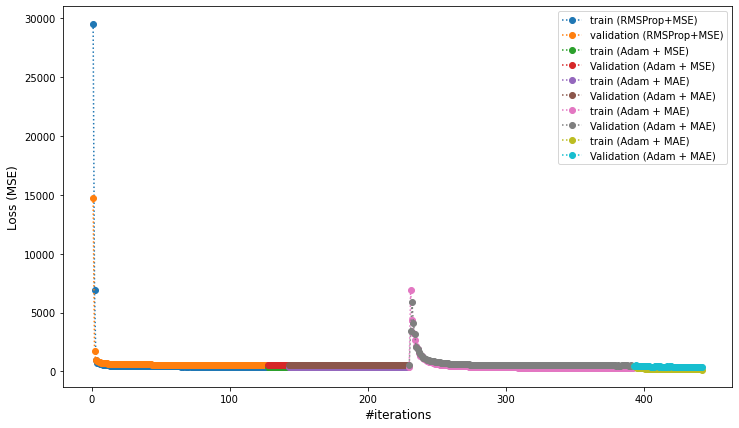

In [ ]:
loss1 = df1["loss"].tolist()
val_loss1 = df1["val_loss"].tolist()

loss2 = [loss1[-1]]+df2["loss"].tolist() 
val_loss2 = [val_loss1[-1]] +df2["val_loss"].tolist()

loss3 = [loss2[-1]] + df3["mean_squared_error"].tolist()
val_loss3 = [val_loss2[-1]] + df3["val_mean_squared_error"].tolist()

loss4 = [loss3[-1]] + df4["loss"].tolist()
val_loss4 = [val_loss3[-1]] + df4["val_loss"].tolist()

loss5 = [val_loss4[-1]] + df5["mean_squared_error"].tolist()
val_loss5 = [val_loss4[-1]] + df5["val_mean_squared_error"].tolist()


plt.figure(figsize=(12,7))
plt.plot(range(1, len(loss1)+1), loss1, 'o:', label='train (RMSProp+MSE)')
plt.plot(range(1, len(val_loss1)+1), val_loss1, 'o:', label = 'validation (RMSProp+MSE)')

plt.plot(range(len(loss1), len(loss1)+len(loss2)), loss2, 'o:', label = "train (Adam + MSE)")
plt.plot(range(len(val_loss1), len(val_loss1)+ len(val_loss2)), val_loss2, 'o:', label = "Validation (Adam + MSE)")

plt.plot(range(len(loss1)+len(loss2)-1, len(loss1)+len(loss2)+len(loss3)-1), loss3, 'o:', label = "train (Adam + MAE)")
plt.plot(range(len(val_loss1)+ len(val_loss2)-1, len(val_loss1)+ len(val_loss2)+len(val_loss3)-1), val_loss3, 'o:', label = "Validation (Adam + MAE)")
#
plt.plot(range(len(loss1)+len(loss2)+len(loss3)-1, len(loss1)+len(loss2)+len(loss3)+len(loss4)-1), loss4, 'o:', label = "train (Adam + MAE)")
plt.plot(range(len(val_loss1)+ len(val_loss2) + len(val_loss3) -1,
               len(val_loss1)+ len(val_loss2)+len(val_loss3)+len(val_loss4)-1), val_loss4, 'o:', label = "Validation (Adam + MAE)")

plt.plot(range(len(loss1)+len(loss2)+len(loss3)+len(loss4)-1, len(loss1)+len(loss2)+len(loss3)+len(loss4)+len(loss5)-1),
         loss5, 'o:', label = "train (Adam + MAE)")
plt.plot(range(len(val_loss1)+ len(val_loss2)+len(val_loss3)+len(val_loss4)-1, 
                len(val_loss1)+ len(val_loss2)+len(val_loss3)+len(val_loss4)+len(val_loss5)-1), 
                val_loss5, 'o:', label = "Validation (Adam + MAE)")

plt.legend()

plt.xlabel("#iterations", fontsize=12)
plt.ylabel("Loss (MSE)", fontsize=12)
plt.show()

#### **Checking some predicted samples**

**Train**

In [ ]:
names = train_df[train_df['filename'].apply(lambda x: x.startswith('0_') or x.startswith("1_") or  x.startswith("gray_"))]['filename'].tolist()

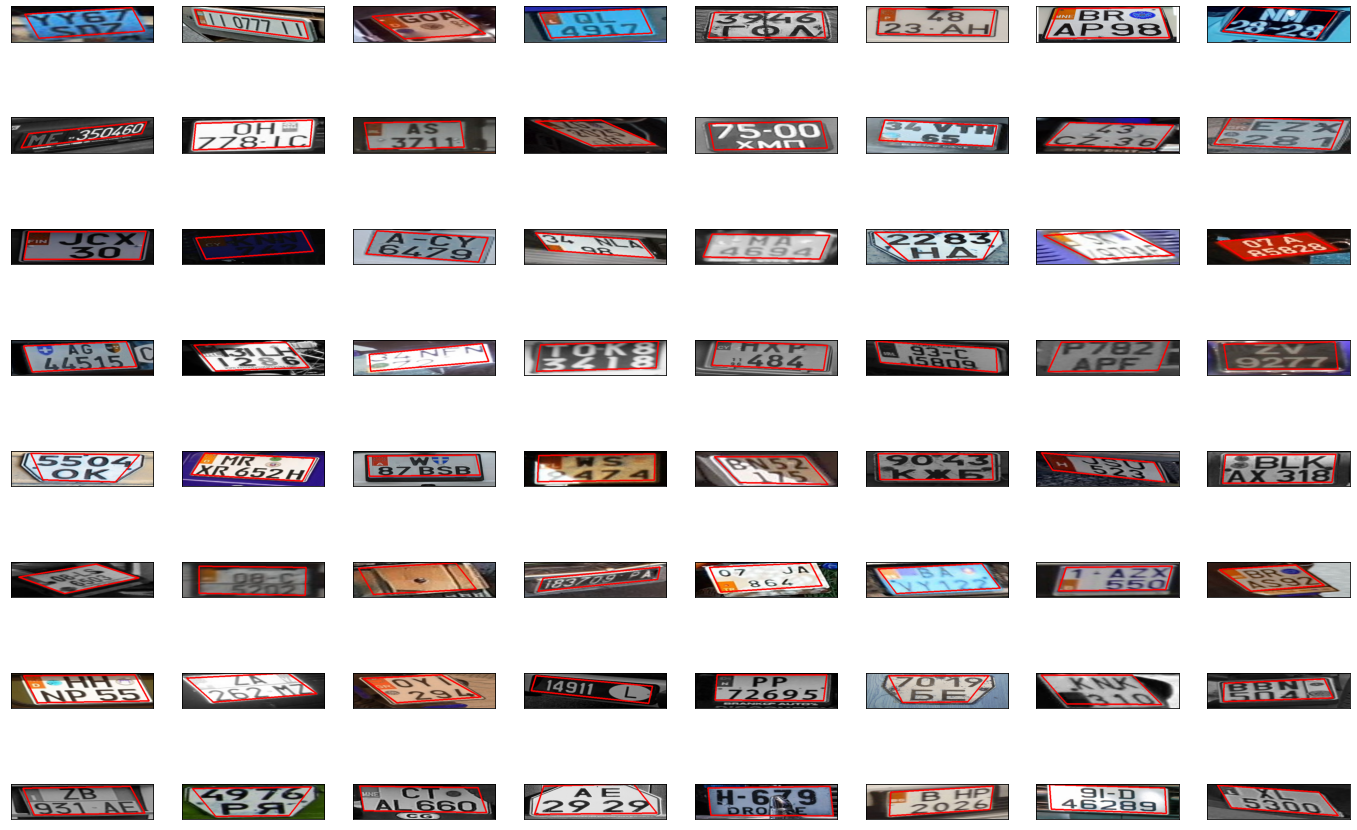

In [ ]:
rows = 8
plt.figure(figsize = (24, rows*2))

for i, name in enumerate(names, 1):
    plt.subplot(rows,8,i)
    img = cv2.imread(f"final-mixed/{name}")
    img = cv2.resize(img, (480, 120))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    preds = model.predict((img.reshape(1, 120, 480, 3)/255).astype(np.float32))

    coords = [[int(x),int(y)] for x,y in zip(preds[0][:4], preds[0][4:])]
    img = cv2.line(img, tuple(coords[0]), tuple(coords[1]), (255,0,0), 4)
    img = cv2.line(img, tuple(coords[1]), tuple(coords[2]), (255,0,0), 4)
    img = cv2.line(img, tuple(coords[2]), tuple(coords[3]), (255,0,0), 4)
    img = cv2.line(img, tuple(coords[3]), tuple(coords[0]), (255,0,0), 4)

    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

    if i >= rows*8:
        break
plt.show()

**Validation**

In [ ]:
names = val_df[val_df['filename'].apply(lambda x: x.startswith('0_') or x.startswith("1_") or  x.startswith("gray_"))]['filename'].tolist()

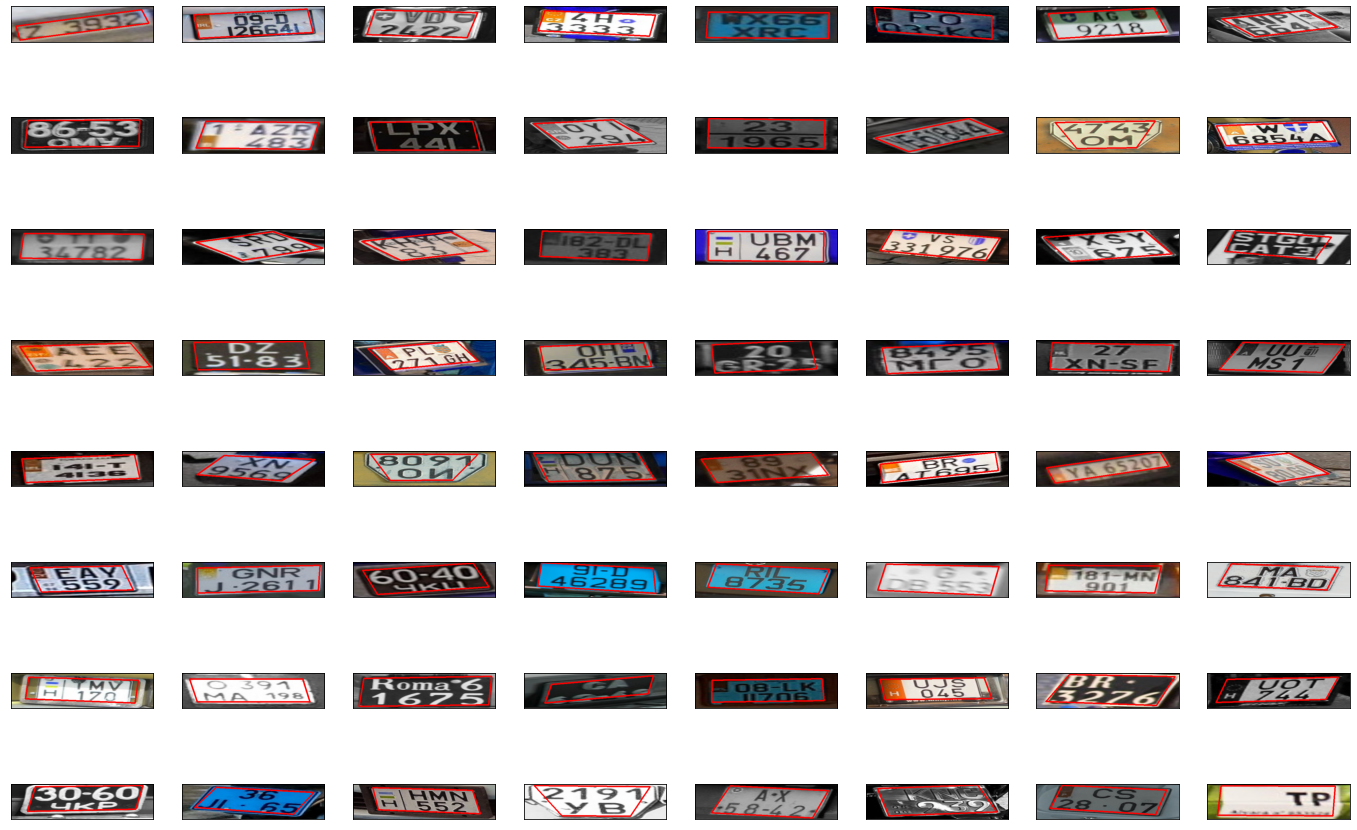

In [ ]:
rows = 8
plt.figure(figsize = (24, rows*2))

for i, name in enumerate(names, 1):
    plt.subplot(rows,8,i)
    img = cv2.imread(f"final-mixed/{name}")
    img = cv2.resize(img, (480, 120))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    preds = model.predict((img.reshape(1, 120, 480, 3)/255).astype(np.float32))

    coords = [[int(x),int(y)] for x,y in zip(preds[0][:4], preds[0][4:])]
    img = cv2.line(img, tuple(coords[0]), tuple(coords[1]), (255,0,0), 4)
    img = cv2.line(img, tuple(coords[1]), tuple(coords[2]), (255,0,0), 4)
    img = cv2.line(img, tuple(coords[2]), tuple(coords[3]), (255,0,0), 4)
    img = cv2.line(img, tuple(coords[3]), tuple(coords[0]), (255,0,0), 4)

    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

    if i >= rows*8:
        break
plt.show()

**Test**

In [ ]:
names = test_df['filename'].tolist()

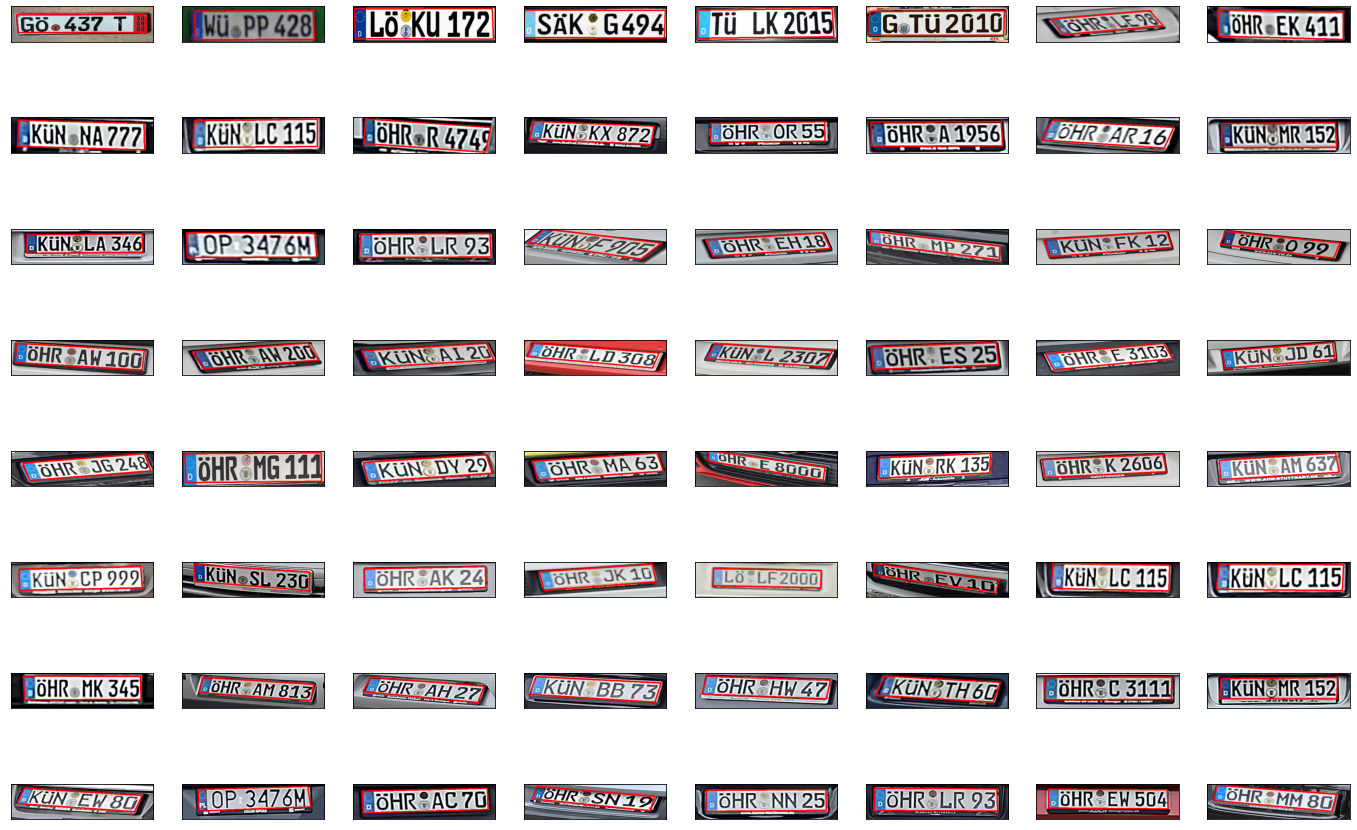

In [ ]:
rows = 8
plt.figure(figsize = (24, rows*2))

for i, name in enumerate(names, 1):
    plt.subplot(rows,8,i)
    img = cv2.imread(f"special-plates/{name}")
    img = cv2.resize(img, (480, 120))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    preds = model.predict((img.reshape(1, 120, 480, 3)/255).astype(np.float32))

    coords = [[int(x),int(y)] for x,y in zip(preds[0][:4], preds[0][4:])]
    img = cv2.line(img, tuple(coords[0]), tuple(coords[1]), (255,0,0), 4)
    img = cv2.line(img, tuple(coords[1]), tuple(coords[2]), (255,0,0), 4)
    img = cv2.line(img, tuple(coords[2]), tuple(coords[3]), (255,0,0), 4)
    img = cv2.line(img, tuple(coords[3]), tuple(coords[0]), (255,0,0), 4)

    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

    if i >= rows*8:
        break
plt.show()